In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

import os, sys

from denoising_assessment_project.utils import metric_compute, stats_compute, stats_plot

# parameters setup 
from denoising_assessment_project.global_vars import global_vars

%matplotlib notebook

import os

In [2]:
# restoring variables from memory (GT images, indices_eval)
%store -r

In [3]:
%who

DataLoader	 a	 cm	 distinct_blob_quantities	 distinct_blob_quantities_new	 distinct_blob_quantities_pickled_td	 functions	 global_vars	 indices	 
indices_eval	 indices_eval_zoom	 indices_td	 indices_td_zoom	 metric_stats	 metric_stats_MS_SSIM	 metric_stats_MS_SSIM_CARE	 metric_stats_MS_SSIM_CARE_beam	 metric_stats_MS_SSIM_CARE_beam_zoom	 
metric_stats_MS_SSIM_N2V	 metric_stats_MS_SSIM_beam	 metric_stats_MS_SSIM_beam_zoom	 metric_stats_NRMSE	 metric_stats_NRMSE_CARE	 metric_stats_NRMSE_CARE_beam	 metric_stats_NRMSE_CARE_beam_zoom	 metric_stats_NRMSE_N2V	 metric_stats_NRMSE_beam	 
metric_stats_NRMSE_beam_zoom	 metric_stats_PSNR	 metric_stats_PSNR_CARE	 metric_stats_PSNR_CARE_beam	 metric_stats_PSNR_CARE_beam_zoom	 metric_stats_PSNR_N2V	 metric_stats_PSNR_beam	 metric_stats_PSNR_beam_zoom	 metric_stats_RMSE	 
metric_stats_RMSE_CARE	 metric_stats_RMSE_CARE_beam	 metric_stats_RMSE_CARE_beam_zoom	 metric_stats_RMSE_N2V	 metric_stats_RMSE_beam	 metric_stats_RMSE_beam_zoom	 metric_stats_SSIM	 

In [4]:
# opening GT images 
with open('/Users/miriamczech/Desktop/denoising_assessment/pickled_data/EVAL/un_noised_images_eval_beam_zoom.pkl', 'rb') as un_noised_images_eval_beam_pickled:
    un_noised_images = pickle.load(un_noised_images_eval_beam_pickled)

In [21]:
# collecting N2V-predicted images into a tensor, ensuring appropriate image loactions relative to GT images
import glob
import fnmatch
from tifffile import imread

#path at which the predicted images are stored 
path = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/predictions/N2V_CPU_run_reindexed/'

predicted_images = os.listdir(path)
predicted_images_len = len(predicted_images)

print(len(os.listdir(path)))

predicted_images_tensor = torch.zeros_like(un_noised_images)
for n in range(0,20):
    if n in range(0,10):
        n = '0{}'.format(n)
    noised_imgs_n_list = glob.glob(os.path.join(path, '{}_*_*.tif'.format(n)))
    for m in range(0,20):
        if n in range(0,10):
            n = '0{}'.format(n)
        if m in range(0,10):
            m = '0{}'.format(m)
        noised_imgs_m_list = fnmatch.filter(noised_imgs_n_list, os.path.join(path, '{}_{}_*.tif'.format(n, m)))
        for i in range(0,50):
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '0{}'.format(i)
            img_i_path = fnmatch.filter(noised_imgs_m_list, os.path.join(path, '{}_{}_{}.tif'.format(n, m, i)))[0]
            #print(img_i_path)
            xy = torch.tensor(imread(img_i_path))
            n = int(n)
            m = int(m)
            i = int(i)
            predicted_images_tensor[n,m,i,:,:] = xy
            

20000


In [22]:
# storing the predicted_images_tensor
predicted_images_N2V_tensor_beam_pickled = pickle.dump(predicted_images_tensor, open("/Users/miriamczech/Desktop/denoising_assessment/pickled_data/EVAL/predicted_images_N2V_cpu_reindexed_tensor.pkl", 'wb'), protocol=4)
%store predicted_images_N2V_tensor_beam_pickled

Stored 'predicted_images_N2V_tensor_beam_pickled' (NoneType)


In [23]:
# CARE: -NRMSE-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.NRMSE_compute(un_noised_images, predicted_images_tensor)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_NRMSE_N2V = stats_compute.set_mean_std_compute(metric_output)

In [24]:
# CARE: -RMSE-
# 4b. Computing RMSE for each image in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.RMSE_compute(un_noised_images, predicted_images_tensor)

#tests 
print(metric_output.shape)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_RMSE_N2V = stats_compute.set_mean_std_compute(metric_output)

torch.Size([20, 20, 50])


In [25]:
# CARE: -PSNR- 
# 4c. Computing PSNR for each image in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.PSNR_compute(un_noised_images, predicted_images_tensor)

#tests 
print(metric_output.shape)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_PSNR_N2V = stats_compute.set_mean_std_compute(metric_output)

torch.Size([20, 20, 50])


In [26]:
# CARE: -SSIM- 
# 4c. Computing SSIM for each image in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.SSIM_compute(un_noised_images, predicted_images_tensor)
#tests 
print(metric_output.shape)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_SSIM_N2V = stats_compute.set_mean_std_compute(metric_output)

torch.Size([20, 20, 50])


In [31]:
# CARE: -MS_SSIM-
# 4c. Computing MS_SSIM for each image in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.MS_SSIM_compute(un_noised_images, predicted_images_tensor)
#tests 
print(metric_output.shape)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_MS_SSIM_N2V = stats_compute.set_mean_std_compute(metric_output)

torch.Size([20, 20, 50])


In [32]:
%store metric_stats_NRMSE_N2V
%store metric_stats_RMSE_N2V
%store metric_stats_PSNR_N2V
%store metric_stats_SSIM_N2V
%store metric_stats_MS_SSIM_N2V

Stored 'metric_stats_NRMSE_N2V' (Tensor)
Stored 'metric_stats_RMSE_N2V' (Tensor)
Stored 'metric_stats_PSNR_N2V' (Tensor)
Stored 'metric_stats_SSIM_N2V' (Tensor)
Stored 'metric_stats_MS_SSIM_N2V' (Tensor)


In [34]:
metric_stats_NRMSE_N2V_zoom = metric_stats_NRMSE_N2V
metric_stats_RMSE_N2V_zoom = metric_stats_RMSE_N2V
metric_stats_PSNR_N2V_zoom = metric_stats_PSNR_N2V
metric_stats_SSIM_N2V_zoom = metric_stats_SSIM_N2V
metric_stats_MS_SSIM_N2V_zoom = metric_stats_MS_SSIM_N2V

%store metric_stats_NRMSE_N2V_zoom
%store metric_stats_RMSE_N2V_zoom
%store metric_stats_PSNR_N2V_zoom
%store metric_stats_SSIM_N2V_zoom
%store metric_stats_MS_SSIM_N2V_zoom

Stored 'metric_stats_NRMSE_N2V_zoom' (Tensor)
Stored 'metric_stats_RMSE_N2V_zoom' (Tensor)
Stored 'metric_stats_PSNR_N2V_zoom' (Tensor)
Stored 'metric_stats_SSIM_N2V_zoom' (Tensor)
Stored 'metric_stats_MS_SSIM_N2V_zoom' (Tensor)


<IPython.core.display.Javascript object>


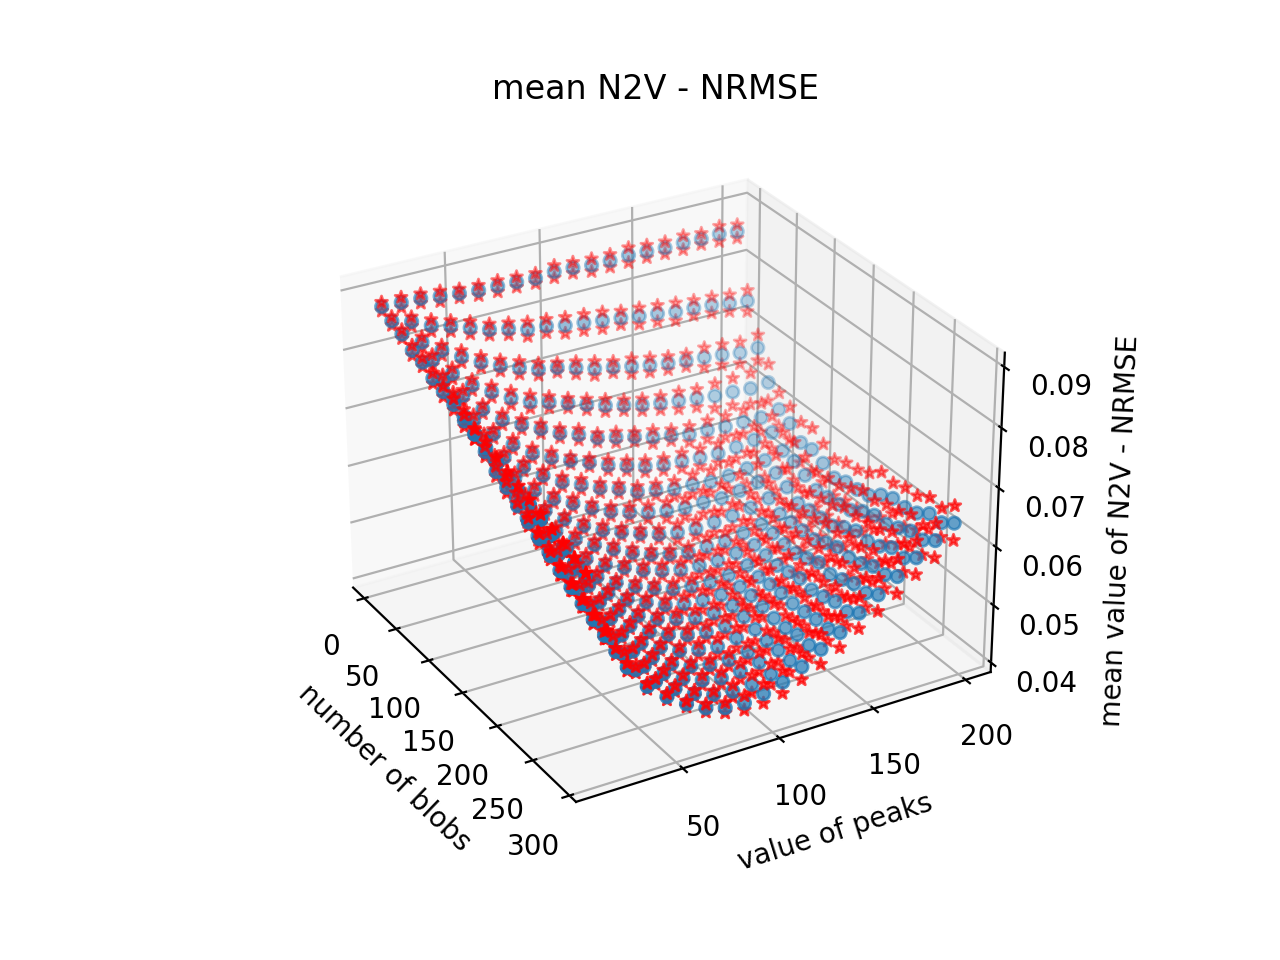

<IPython.core.display.Javascript object>


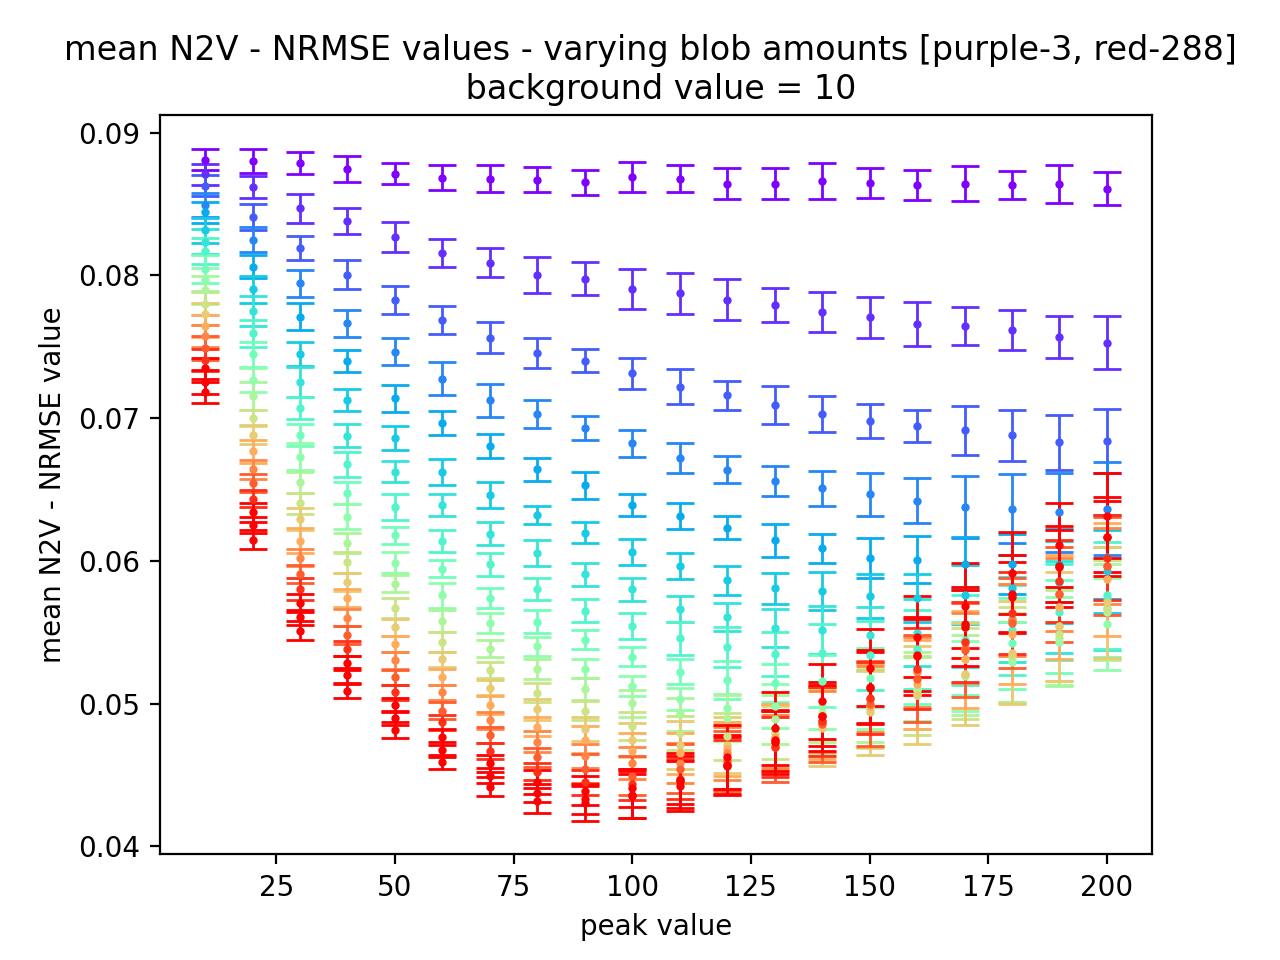

<IPython.core.display.Javascript object>


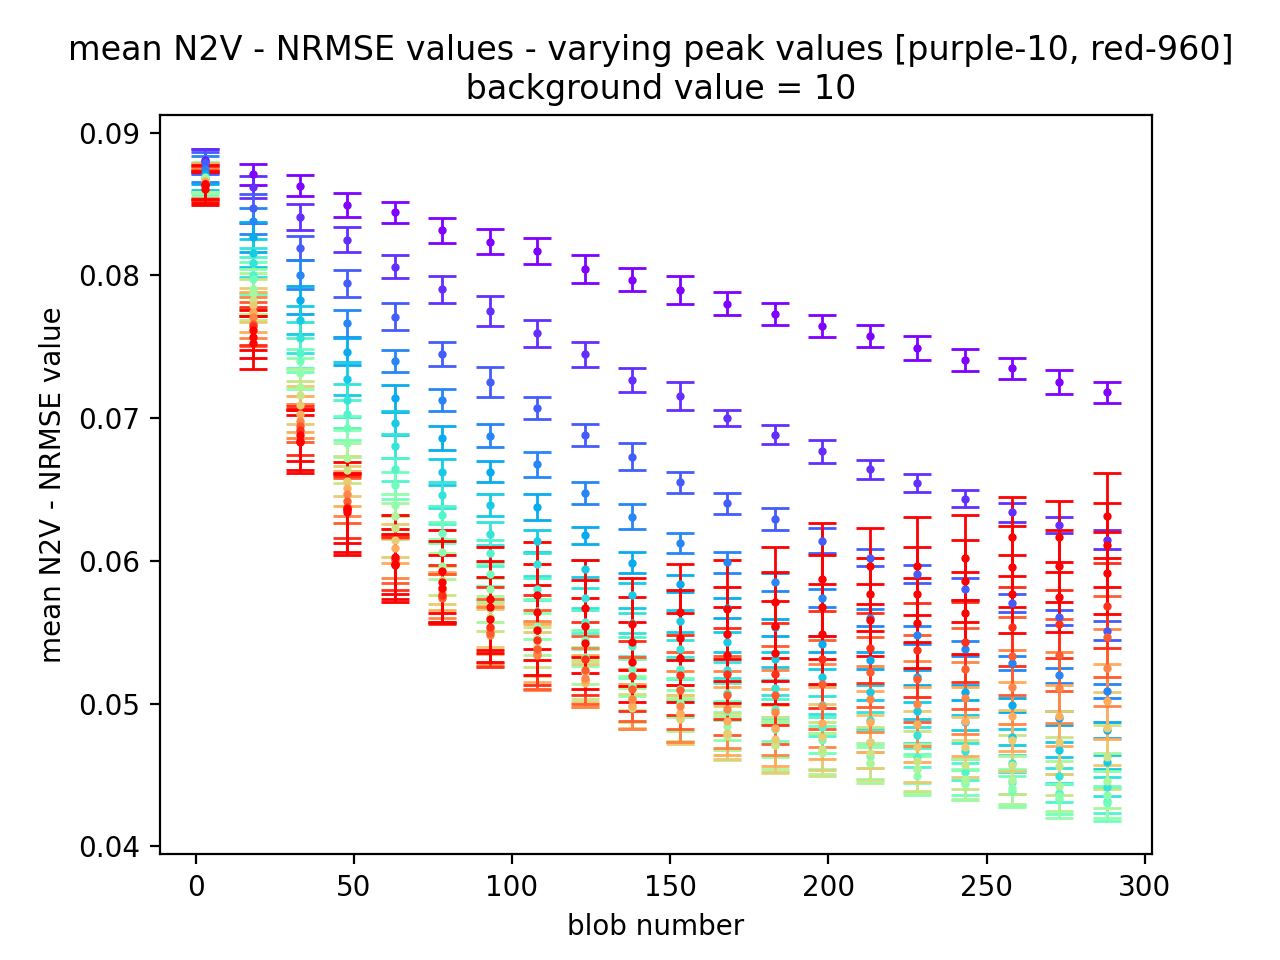

In [40]:
# N2V: -NRMSE-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_NRMSE_N2V_zoom, indices_eval_zoom, 'N2V - NRMSE')

<IPython.core.display.Javascript object>


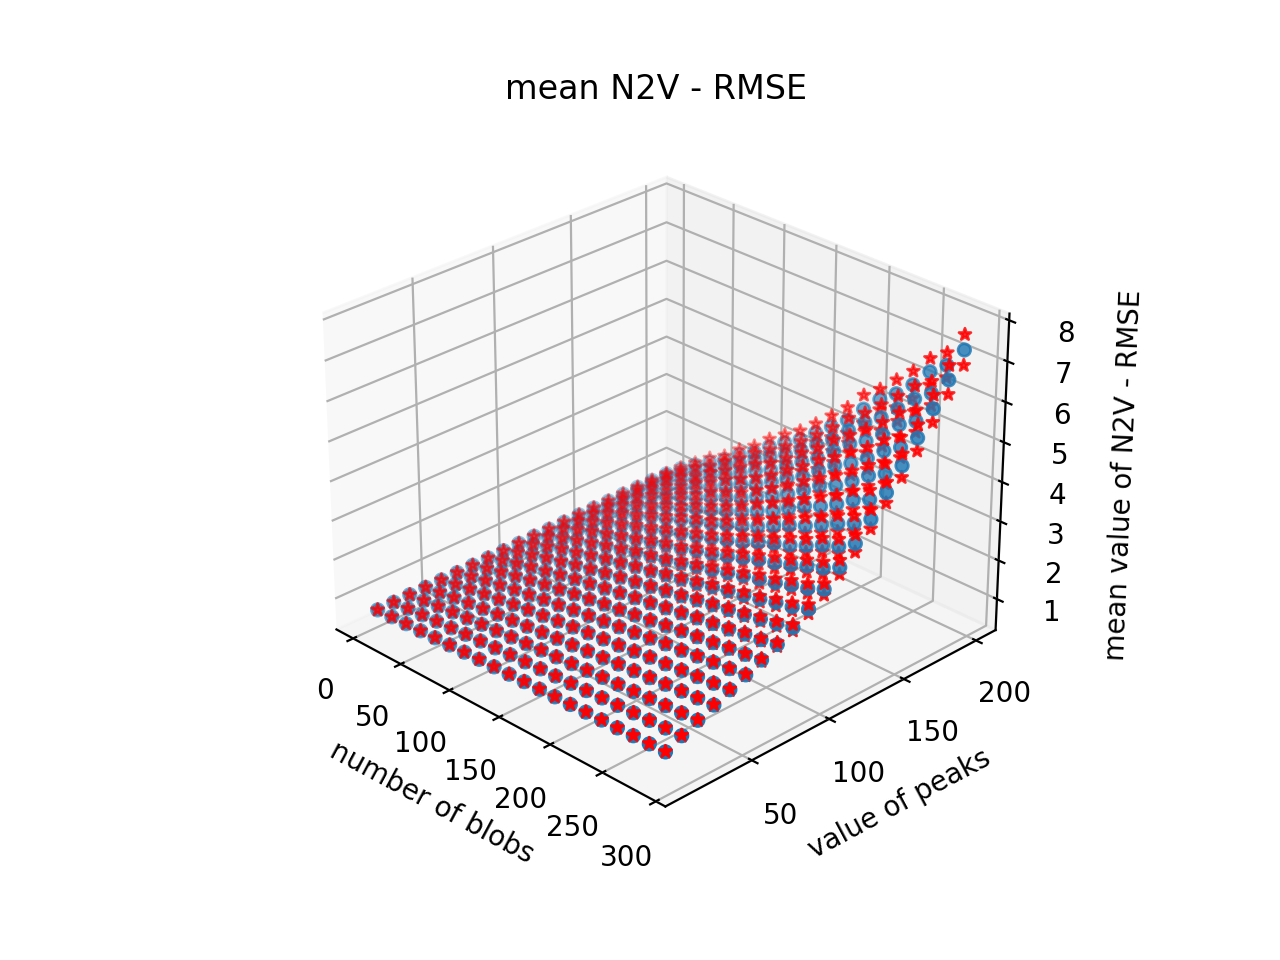

<IPython.core.display.Javascript object>


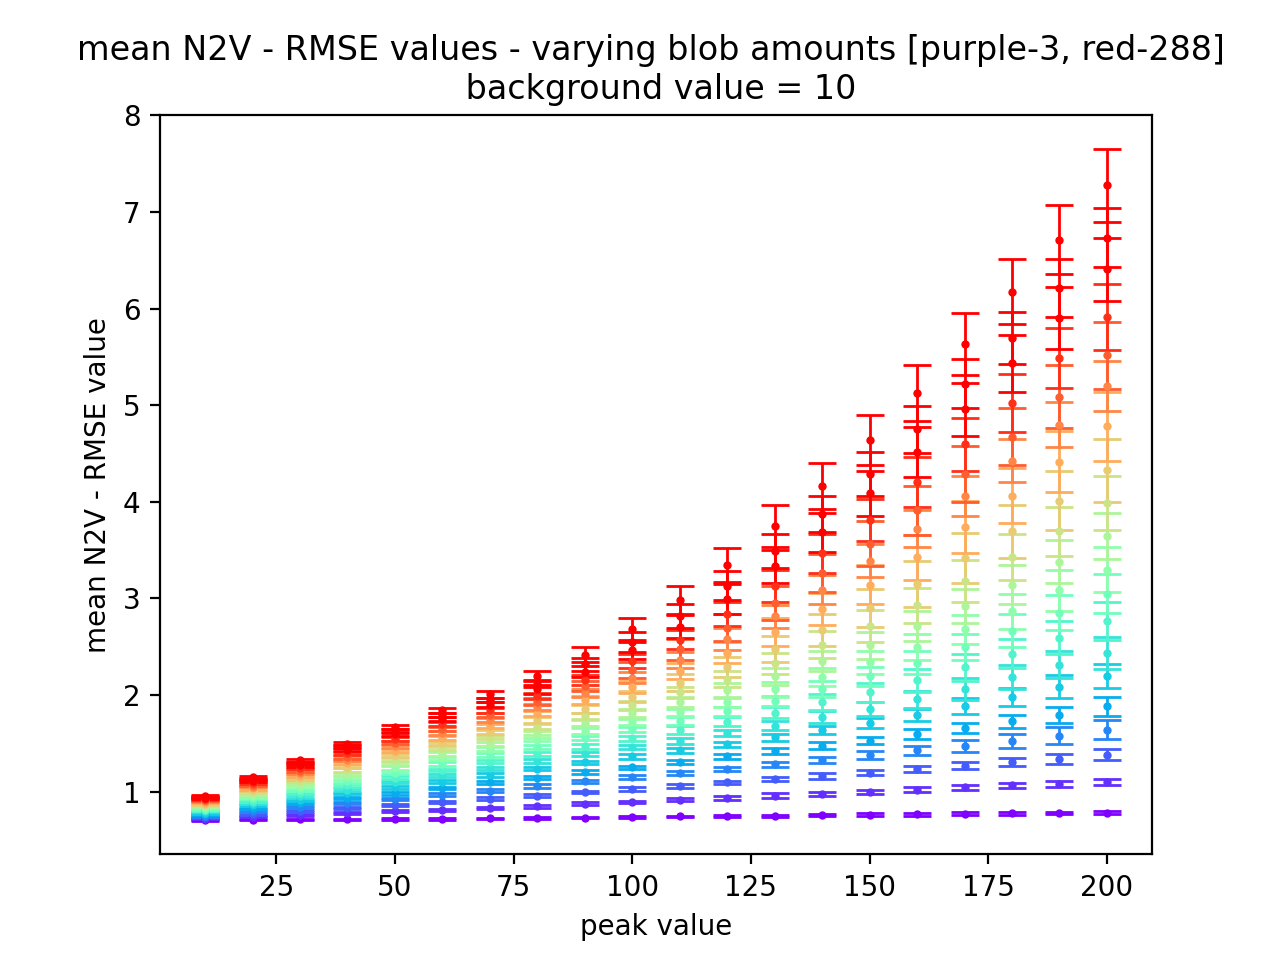

<IPython.core.display.Javascript object>


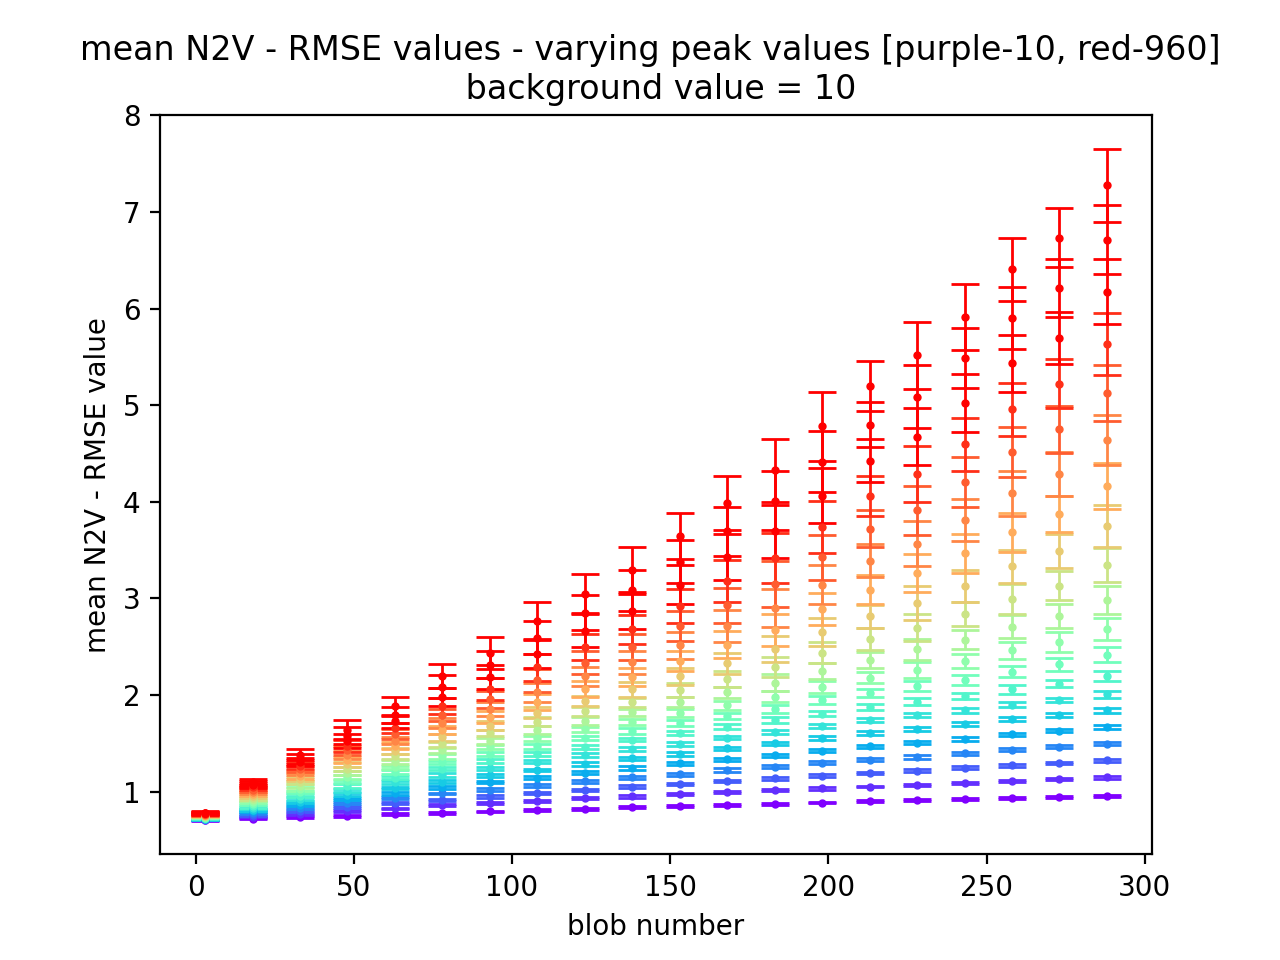

In [39]:
# CARE: -RMSE-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_RMSE_N2V_zoom, indices_eval_zoom, 'N2V - RMSE')

<IPython.core.display.Javascript object>


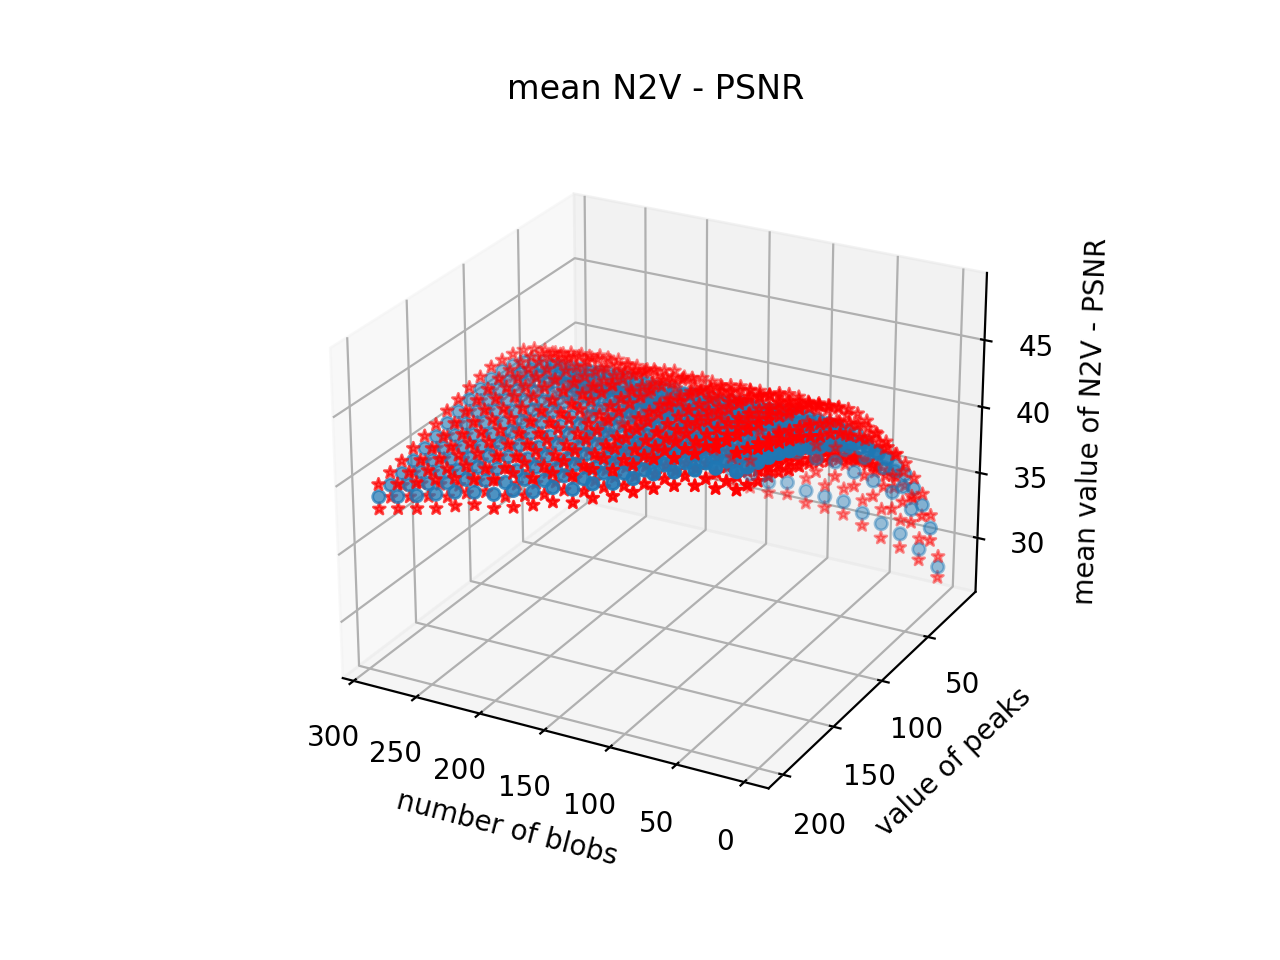

<IPython.core.display.Javascript object>


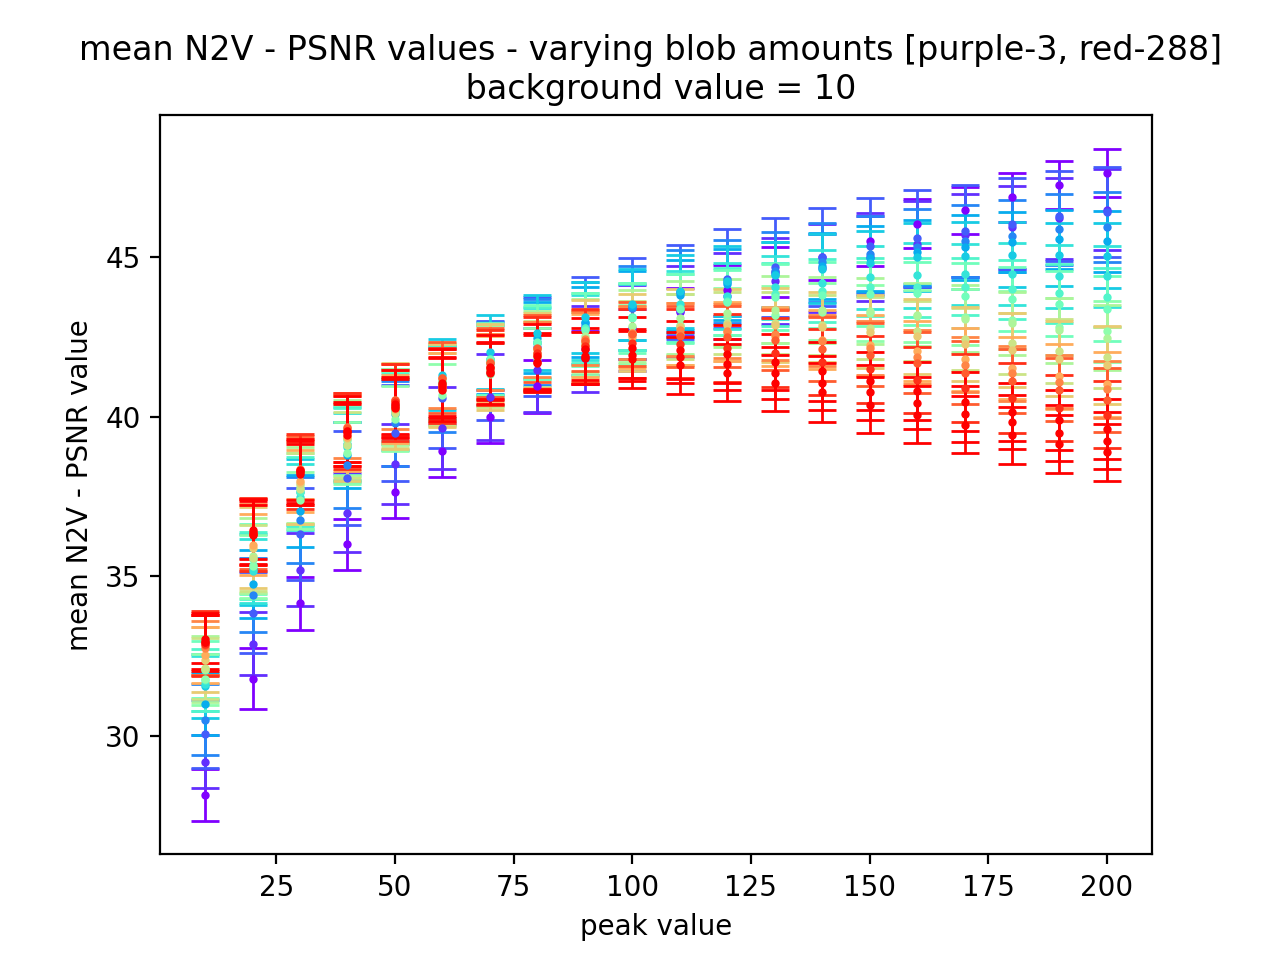

<IPython.core.display.Javascript object>


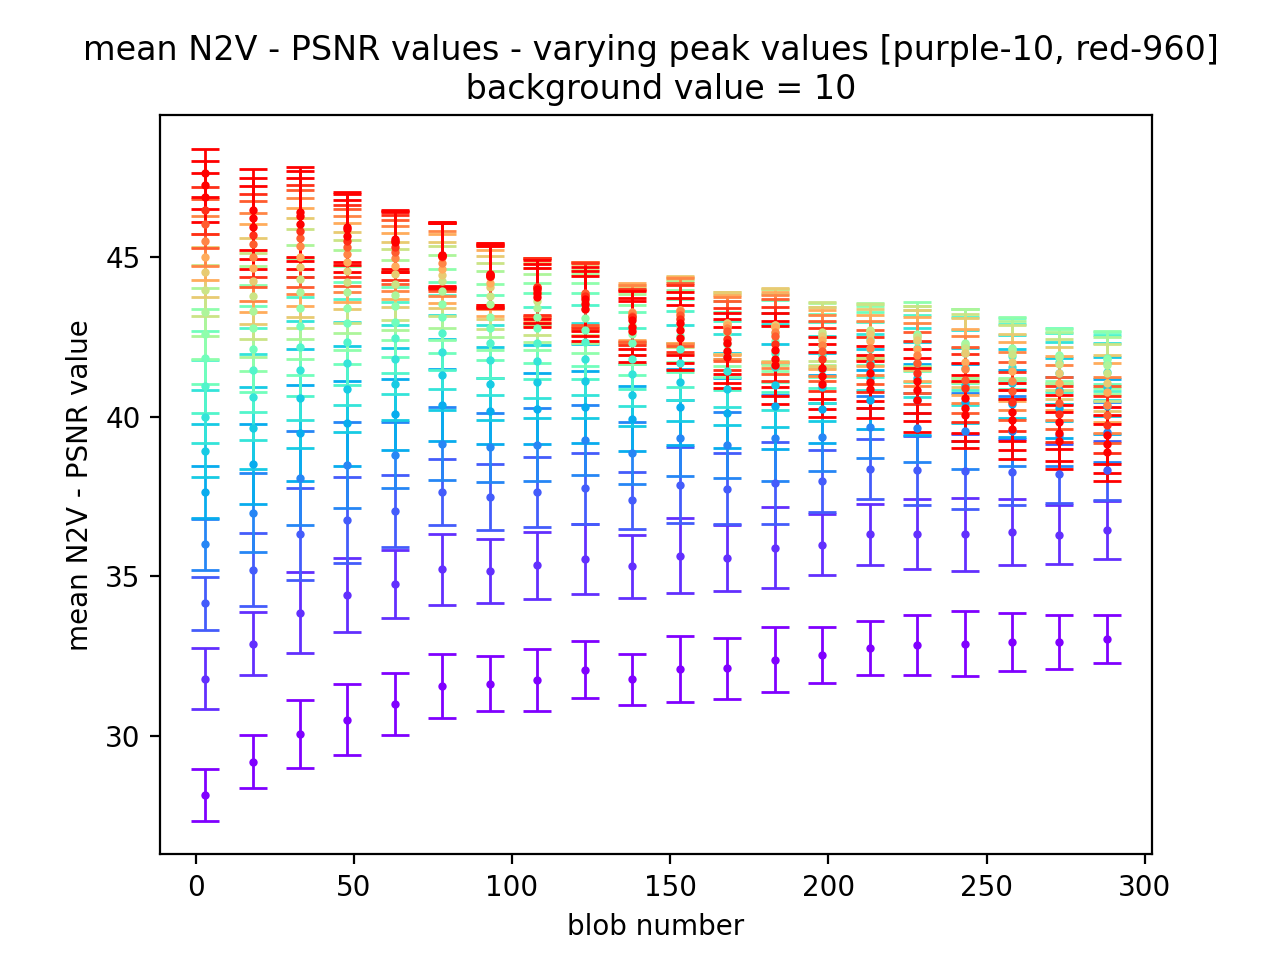

In [38]:
# CARE: -PSNR-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_PSNR_N2V_zoom, indices_eval_zoom, 'N2V - PSNR')

<IPython.core.display.Javascript object>


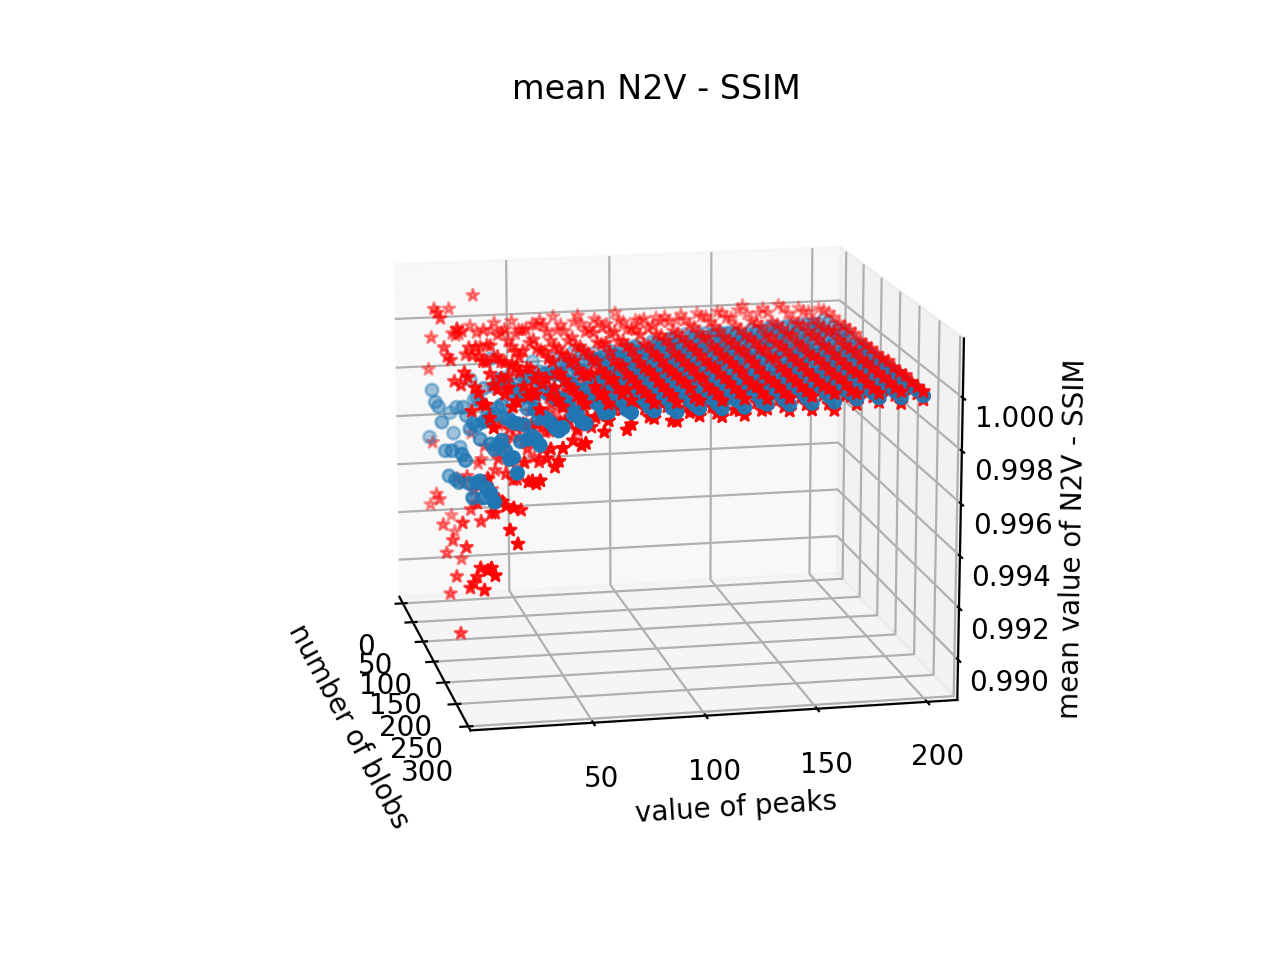

<IPython.core.display.Javascript object>


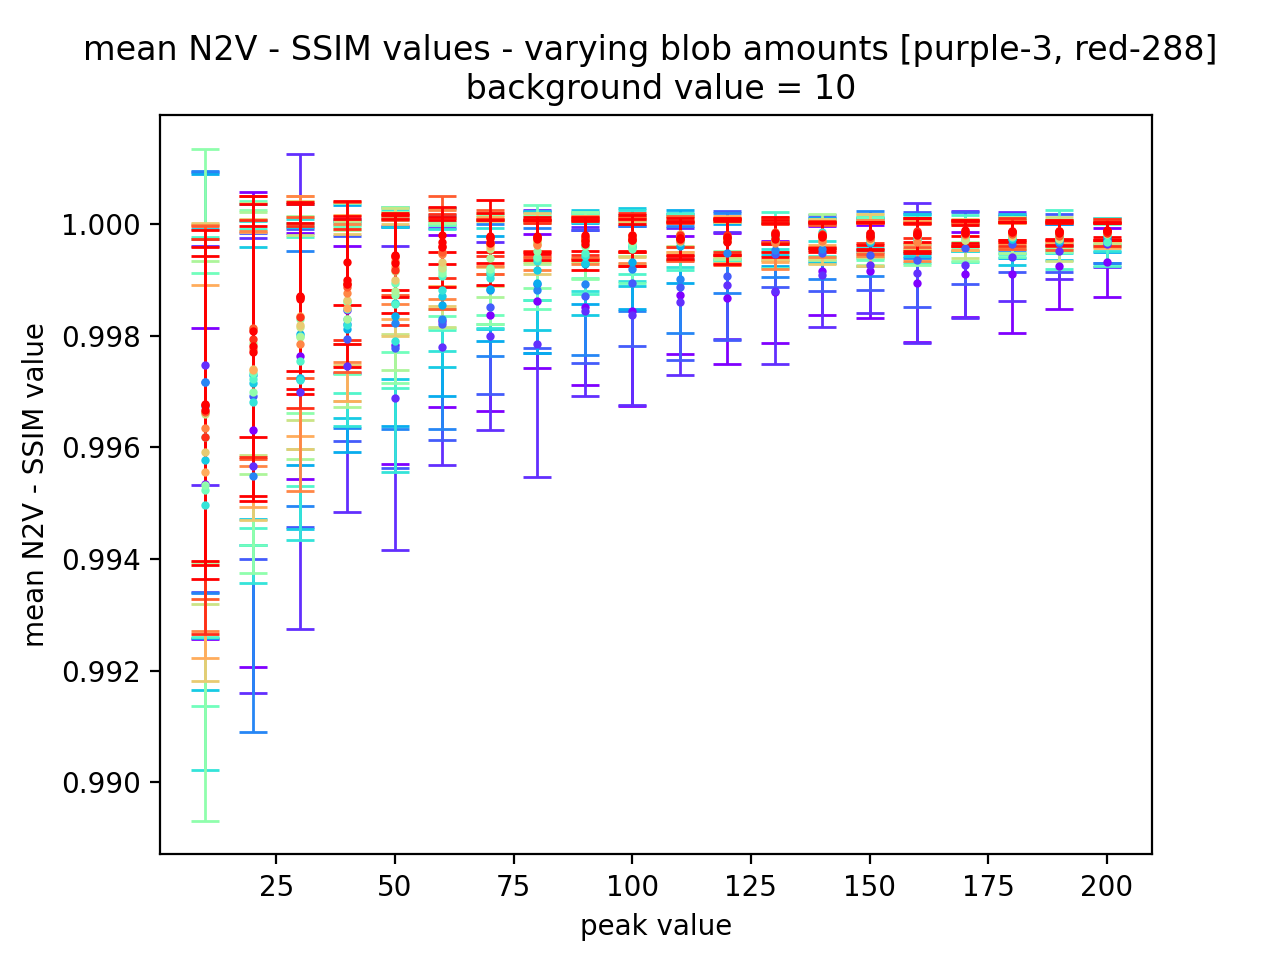

<IPython.core.display.Javascript object>


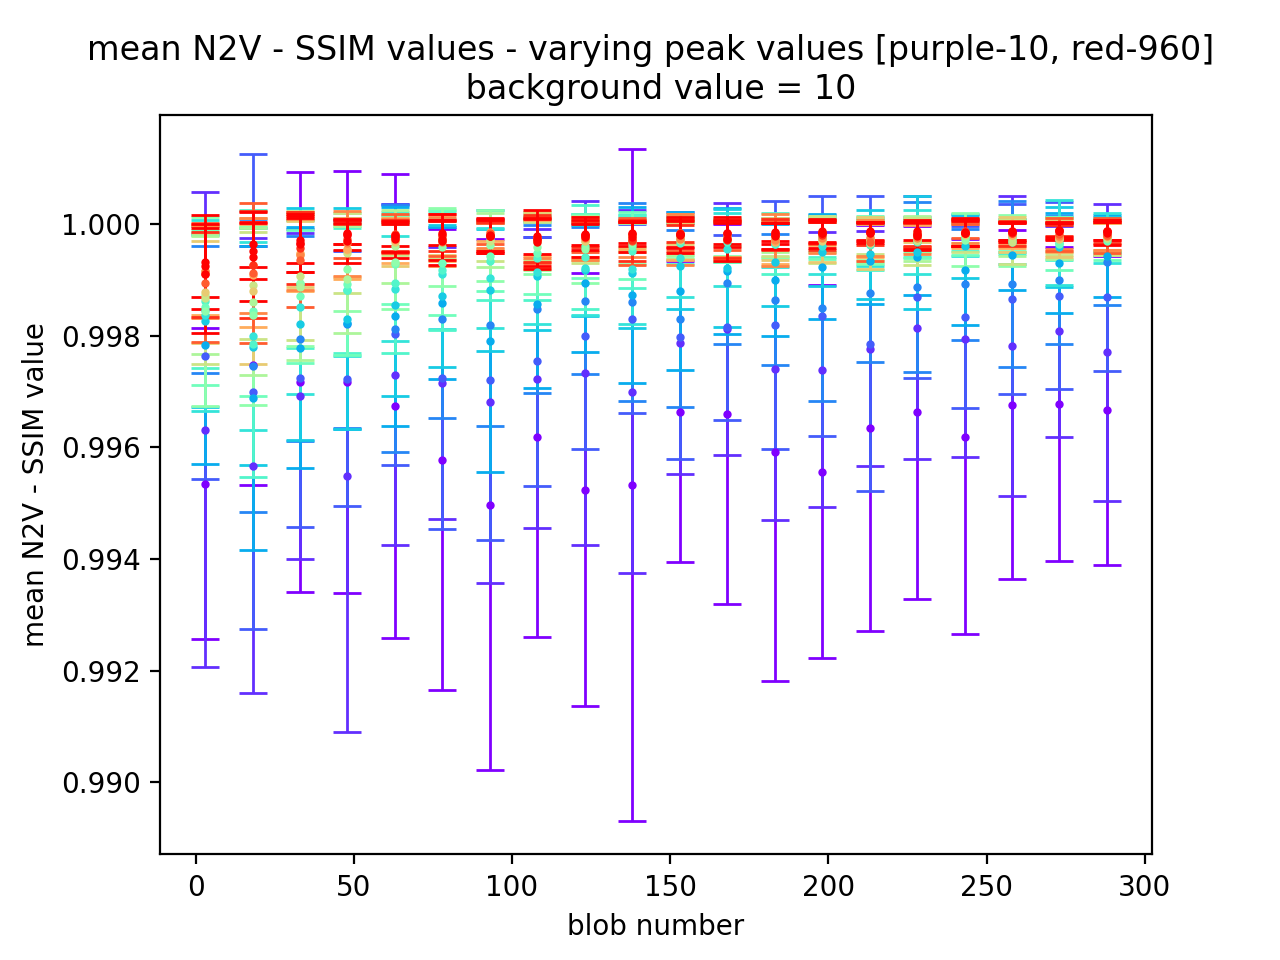

In [36]:
# CARE: -SSIM-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_SSIM_N2V_zoom, indices_eval_zoom, 'N2V - SSIM')

<IPython.core.display.Javascript object>


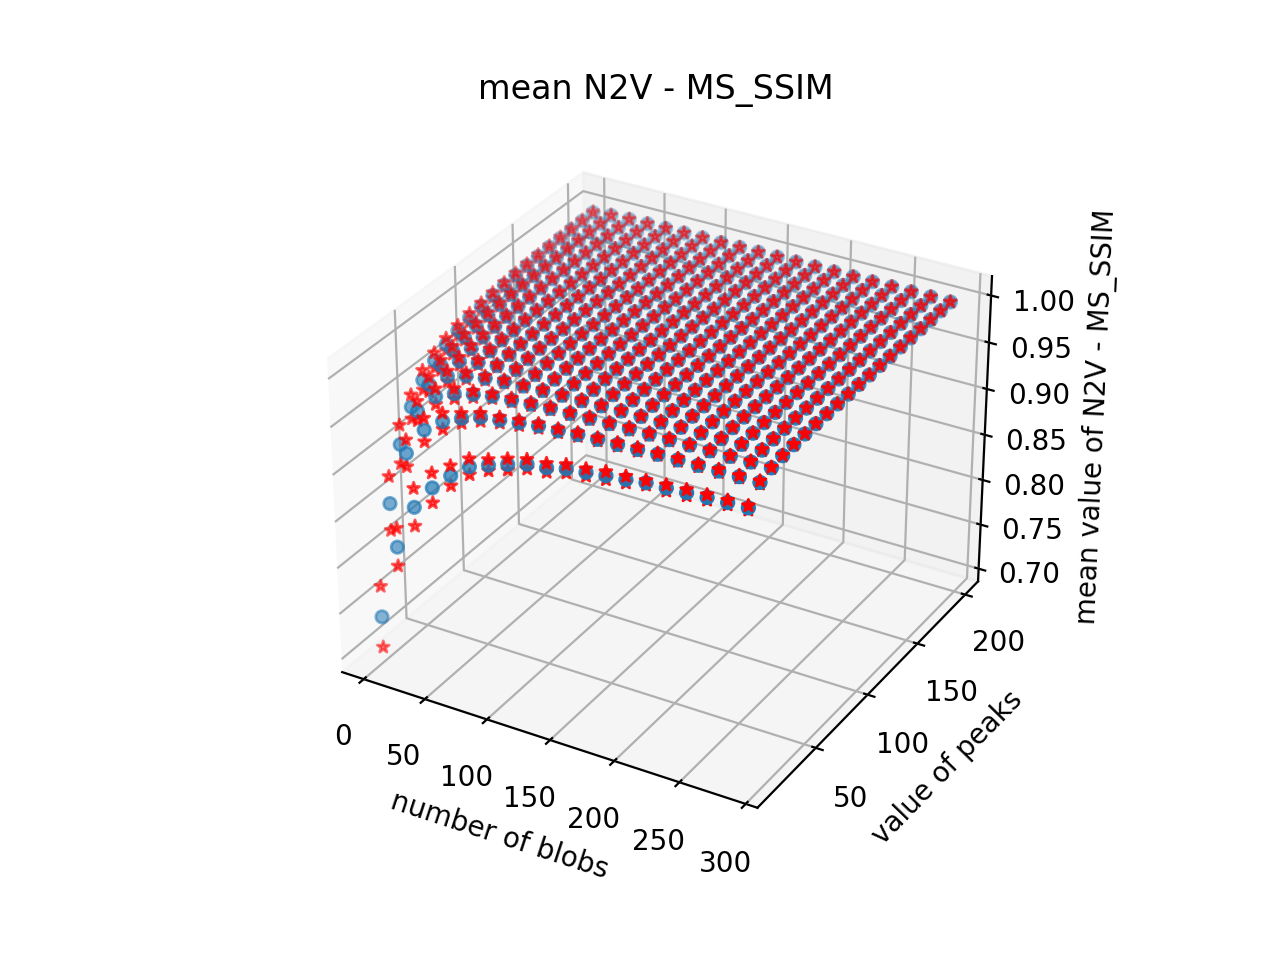

<IPython.core.display.Javascript object>


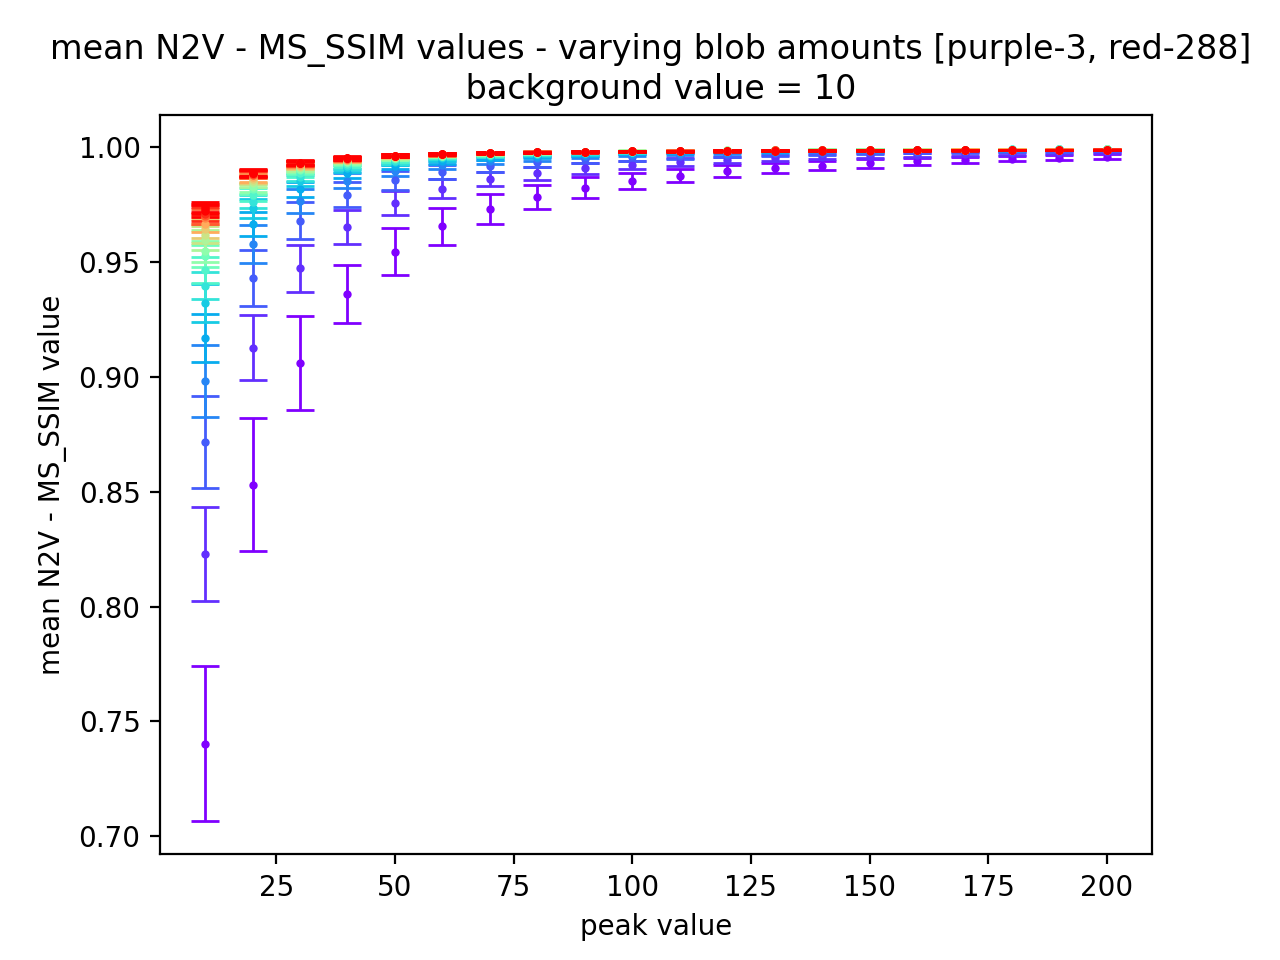

<IPython.core.display.Javascript object>


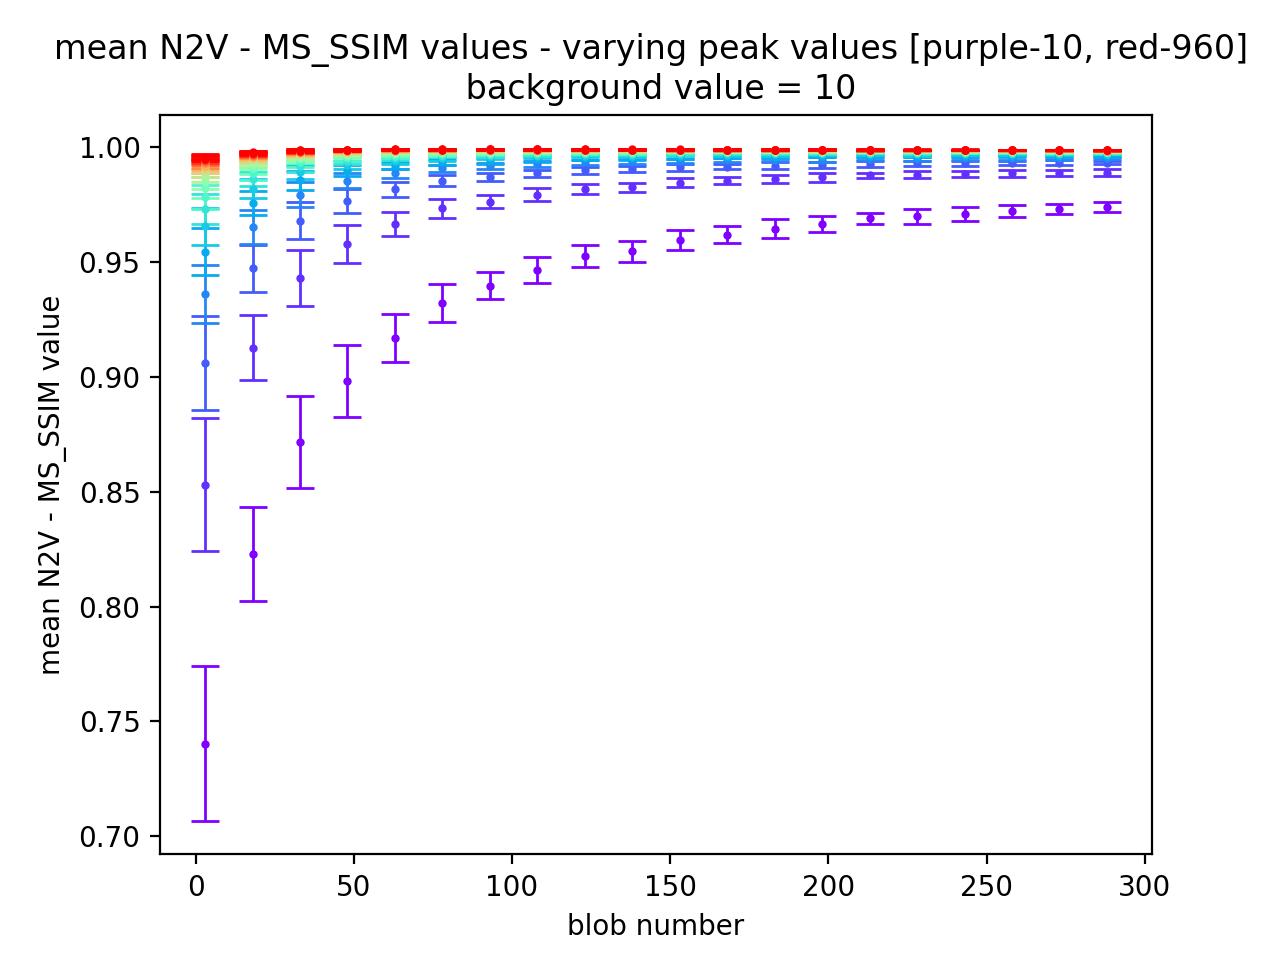

In [37]:
# CARE: -MS_SSIM-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_MS_SSIM_N2V_zoom, indices_eval_zoom, 'N2V - MS_SSIM')